## COMP411/511  HW4
### Deadline: 8 January 2025, 23.59 

You have **TODOs** in this code. They are all marked with `TODO` in comments.  
Your task is to fill them in with the correct code. Do **not** change any other code.  

You also have some questions to answer. They are marked with `QA` as markdown cells.  

---

## Parts:

### **1: Action Recognition on KTH Dataset** *(36 pts)*
1.1: **QA** *(4 pts)*

1.2: **Custom LSTM** *(12 pts)*

1.3: **Action Recognition Model** *(20 pts)*


---

### **2: Image Classification on Tiny Imagenet** *(64 pts)*
2.1: **Vision Transformer** *(40 pts)*

2.2: **Training on Tiny ImageNet** *(20 pts)*

2.3: **QA** *(4 pts)*



---

### **Total: 100 points**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
from torchvision.utils import make_grid

import torch.optim as optim
import matplotlib.pyplot as plt
import math

from torchvision import datasets
from torchvision.datasets import ImageFolder
import cv2

# Part 1: Action Recognition on KTH Dataset

In [4]:
# # First, download the dataset from Kaggle and unzip it into the ./kth directory
# !mkdir -p kth
# !cd kth && curl -L -o kth-dataset-complete.zip https://www.kaggle.com/api/v1/datasets/download/rishita26/kth-dataset-complete
# !cd kth && unzip -q kth-dataset-complete.zip

In [5]:
# Path to the extracted dataset
dataset_path = "./kth"
actions = ['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']

def preprocess_video(video_path, img_size=(64, 64), seq_length=32):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while frame_count < seq_length:
        ret, frame = cap.read()
        if not ret:  # Stop if no more frames are available
            break

        # Resize and normalize
        frame = cv2.resize(frame, img_size)
        frame = frame / 255.0  # Normalize to [0, 1]
        yield frame

        frame_count += 1

    cap.release()


# We already have the video frames preprocessed and saved in the dataset directory
class KTHDataset(Dataset):
    def __init__(self, root_dir, actions, seq_length=32, transform=None):
        self.root_dir = root_dir
        self.actions = actions
        self.seq_length = seq_length
        self.transform = transform
        self.data = []  # Stores file paths and labels

        # Load paths instead of preprocessed data
        for label, action in enumerate(actions):
            action_dir = os.path.join(root_dir, action)
            for video_file in os.listdir(action_dir):
                video_path = os.path.join(action_dir, video_file)
                self.data.append((video_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, label = self.data[idx]

        # Use generator to process frames on-the-fly
        frames = []
        for frame in preprocess_video(video_path, seq_length=self.seq_length):
            frames.append(frame)

        # Ensure frames have the correct length
        if len(frames) < self.seq_length:
            raise ValueError(f"Video {video_path} has fewer than {self.seq_length} frames.")

        # Convert to tensor and apply transformation
        frames = np.array(frames)  # (seq_length, height, width, channels)
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])

        return frames.float(), label

# Transform for frames
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

# Initialize dataset
dataset = KTHDataset(root_dir=dataset_path, actions=actions, seq_length=32, transform=transform)

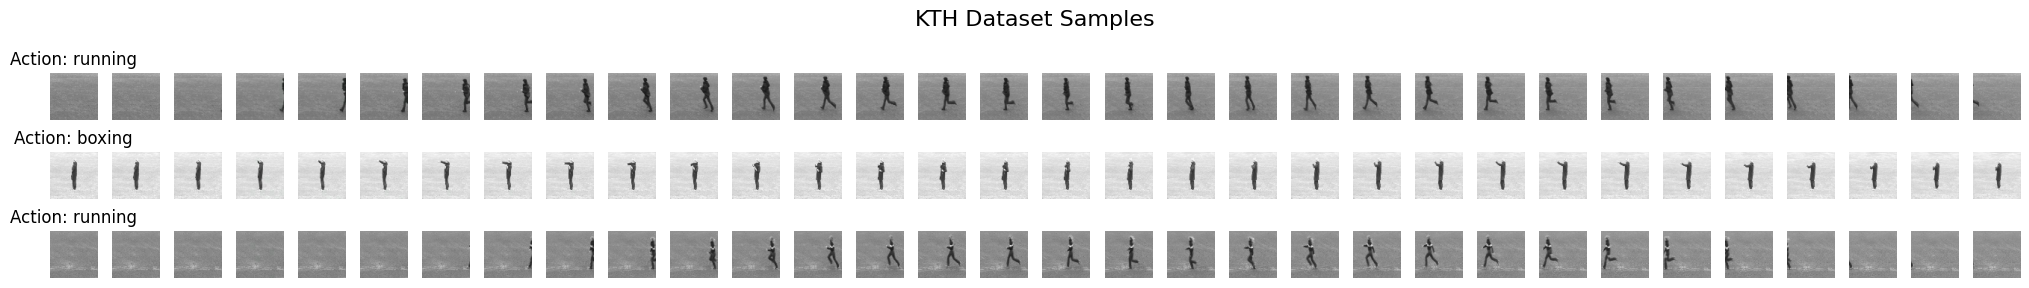

In [6]:
# Visualization function
def visualize_kth_sample(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, dataset.seq_length, figsize=(20, 3))
    fig.suptitle('KTH Dataset Samples', fontsize=16)

    # Sample random indices
    sample_indices = np.random.choice(len(dataset), size=num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        frames, label = dataset[idx]  # Get frames and label
        label_name = dataset.actions[label] if hasattr(dataset, 'actions') else label

        for j in range(dataset.seq_length):
            frame = frames[j].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
            axes[i, j].imshow(frame / 2 + 0.5)  # Unnormalize and show
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"Action: {label_name}")

    plt.tight_layout()
    plt.show()

# Example: Visualize 3 random samples
visualize_kth_sample(dataset, num_samples=3)

# Part 1.1: QA (4 pts)

Q: How many samples are there in the dataset?

A: 599 samples.

---

Q: What is the shape of each frame in the dataset?

A: 64x64

---

Q: How many unique classes are there in the dataset? What are they?

A: 6 classes: ['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking']

---

Q: Why did we use the seq_length=32 in the KTHDataset class? What happens if we use a different value?

A: It sets the maximal amount of frames for each data sample. If we used a larger number than our data samples would be longer videos.

# Part 1.2: Custom LSTM (6 + 6 pts)

In [7]:
# In this part, you need to implement the LSTMCell and use it to implement the LSTM network.

# TODO: Implement the LSTMCell class (6 pts)
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # == TODO ==
        # x_t + h_t (of size hidden_size) -> hidden_size * gate_count_per_cell
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.candidate_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        # == TODO ==

    def forward(self, x, hidden):
        h_prev, c_prev = hidden  # Previous hidden and cell states

        # == TODO ==
        combined = torch.cat([x, h_prev], dim=1)
        
        f_t = torch.sigmoid(self.forget_gate(combined))
        i_t = torch.sigmoid(self.input_gate(combined))
        g_t = torch.tanh(self.candidate_gate(combined))
        o_t = torch.sigmoid(self.output_gate(combined))
        
        # Cell state update
        c_t = f_t * c_prev + i_t * g_t
        
        # Hidden state update
        h_t = o_t * torch.tanh(c_t)

        # == === ==

        return h_t, c_t

# TODO: Implement the LSTM class, which stacks multiple LSTM cells (6 pts)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Stack LSTM cells for each layer
        self.cells = nn.ModuleList([
            LSTMCell(input_size if layer == 0 else hidden_size, hidden_size)
            for layer in range(num_layers)
        ])

    def forward(self, x):
        # :args x: (batch_size, seq_length, input_size)
        
        batch_size, seq_length, input_size = x.size()

        # === TODO ===
        h = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        outputs = []
        
        # Iterate over each timestep in the sequence
        for t in range(seq_length):
            x_t = x[:, t, :]  # Extract the input at timestep t

            # Pass through each layer sequentially
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.cells[layer](x_t, (h[layer], c[layer]))
                x_t = h[layer]  # Output of the current layer becomes input to the next

            outputs.append(h[-1])  # Only store the output of the final layer

        # Stack outputs to shape (batch_size, seq_length, hidden_size)
        outputs = torch.stack(outputs, dim=1)
       
        # === TODO ===

        return outputs, (h[-1], c[-1])

# Part 1.3: Action Recognition Model (10 + 10 pts)

Epoch 1/40 -> Train Loss: 1.7058, Train Acc: 24.63%, Val Loss: 1.4415, Val Acc: 34.17%
Epoch 2/40 -> Train Loss: 1.2849, Train Acc: 35.28%, Val Loss: 1.1546, Val Acc: 40.00%
Epoch 3/40 -> Train Loss: 1.1205, Train Acc: 40.29%, Val Loss: 1.1236, Val Acc: 35.83%
Epoch 4/40 -> Train Loss: 1.0512, Train Acc: 46.35%, Val Loss: 1.0865, Val Acc: 45.00%
Epoch 5/40 -> Train Loss: 0.9710, Train Acc: 50.52%, Val Loss: 1.0679, Val Acc: 46.67%
Epoch 6/40 -> Train Loss: 0.9290, Train Acc: 53.24%, Val Loss: 1.0322, Val Acc: 46.67%
Epoch 7/40 -> Train Loss: 0.8836, Train Acc: 56.78%, Val Loss: 1.0096, Val Acc: 50.00%
Epoch 8/40 -> Train Loss: 0.8318, Train Acc: 61.38%, Val Loss: 0.9395, Val Acc: 52.50%
Epoch 9/40 -> Train Loss: 0.7593, Train Acc: 66.60%, Val Loss: 0.9275, Val Acc: 58.33%
Epoch 10/40 -> Train Loss: 0.7483, Train Acc: 69.94%, Val Loss: 0.9947, Val Acc: 56.67%
Epoch 11/40 -> Train Loss: 0.6932, Train Acc: 70.56%, Val Loss: 0.8535, Val Acc: 60.00%
Epoch 12/40 -> Train Loss: 0.6602, Train 

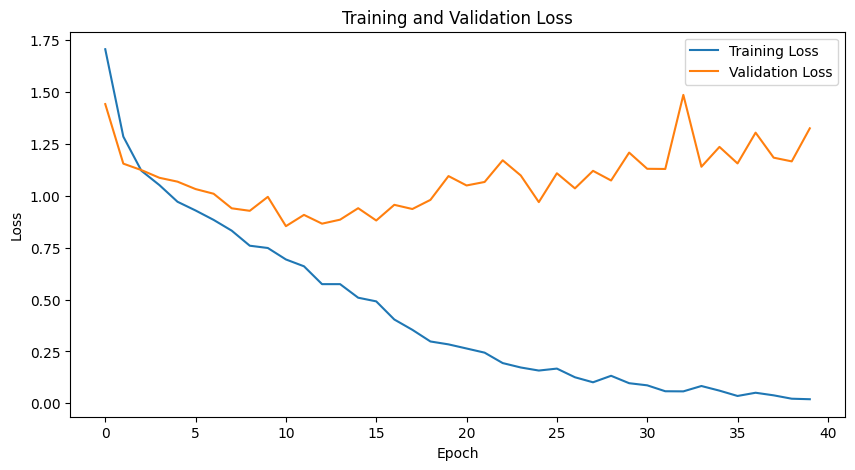

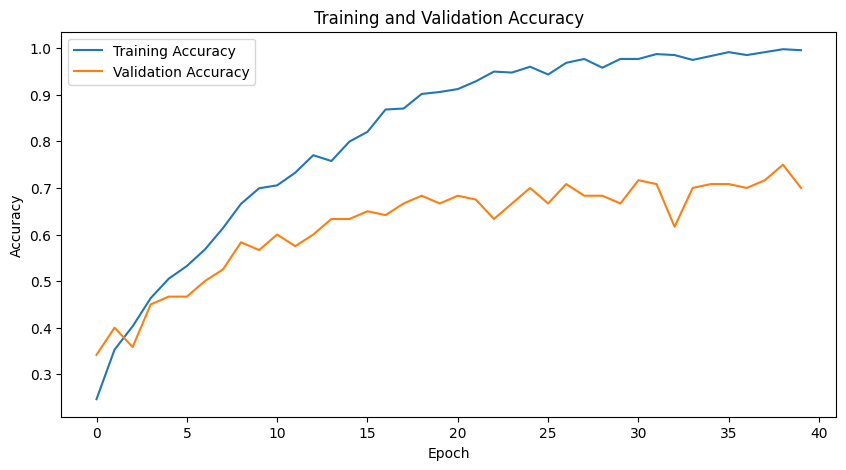

Confusion Matrix:
[[17  3  1  0  0  0]
 [ 2 14  0  0  0  0]
 [ 2  7 12  0  0  0]
 [ 0  0  0 12  6  5]
 [ 0  0  0  6 14  0]
 [ 0  0  0  4  0 15]]


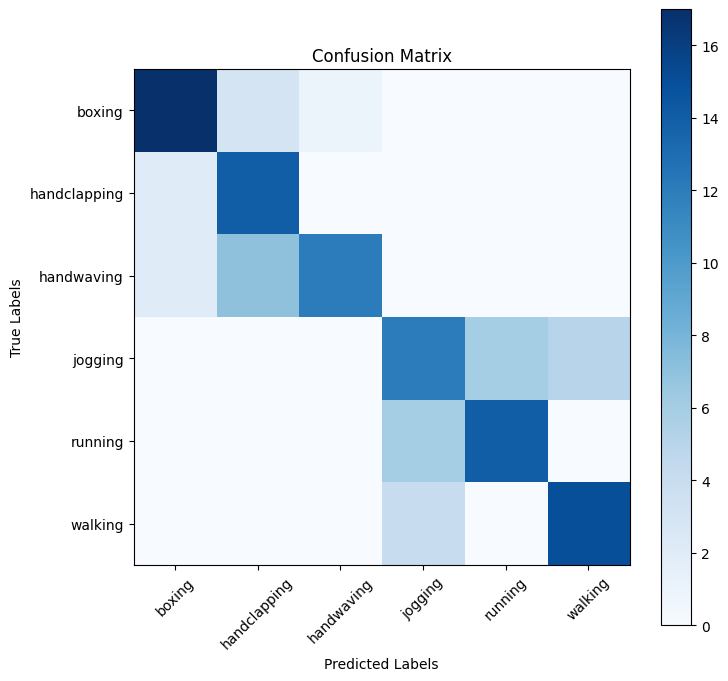

Final Validation Accuracy: 70.00%


In [8]:
# In this part, you train an action recognition model on the KTH dataset.


# TODO: Implement the ActionRecognitionModel class (10 pts)
#       There should be 
#           i) CNN to extract features from each frame.
#           ii) LSTM (2 layers) to capture temporal dependencies. You should use the LSTM class defined above 
#           iii) Fully connected layer to classify actions
#       You can design the CNN architecture as you like, but you do not need a deep CNN for this task.
#
class ActionRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(ActionRecognitionModel, self).__init__()

        # === TODO ===
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (C, H, W) -> (16, H, W)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (16, H, W) -> (16, H/2, W/2)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # (16, H/2, W/2) -> (32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # (32, H/2, W/2) -> (32, H/4, W/4)
            nn.Flatten()                                           # Flatten spatial dimensions
        )
        h = 64
        w = 64
        # Calculate CNN output size (flattened feature size)
        self.cnn_feature_size = 32 * (h // 4) * (w // 4)

        # ii) LSTM (2 layers) to capture temporal dependencies
        hidden_size = 128
        self.lstm = LSTM(self.cnn_feature_size, hidden_size, num_layers=2)

        # iii) Fully connected layer to classify actions
        self.fc = nn.Linear(hidden_size, num_classes)

        # === === ===


    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        # === TODO ===
        x = x.view(batch_size * seq_len, c, h, w)  # Combine batch and sequence dimensions

        # Extract features for each frame using the CNN
        features = self.cnn(x)  # Shape: (batch_size * seq_len, cnn_feature_size)

        # Reshape features back to (batch_size, seq_len, cnn_feature_size)
        features = features.view(batch_size, seq_len, -1)

        # Pass through LSTM to capture temporal dependencies
        lstm_output, (h, c) = self.lstm(features)  # lstm_output: (batch_size, seq_len, hidden_size)

        # Use the last timestep output for classification
        final_output = lstm_output[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Fully connected layer for action classification
        x = self.fc(final_output)  # Shape: (batch_size, num_classes)
        # === === ===
        return x

torch.manual_seed(0)
np.random.seed(0)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# TODO: Train the model (10 pts)
# Train the model for maximum of 40 epochs, and visualize the training and validation losses
# You are expected to achieve a validation accuracy of at least 70%.
# In the end you should visualize the confusion matrix and print the accuracy.
# You can learn more on how to plot the multi-class confusion matrix from here: https://scikit-learn.org/1.5/modules/model_evaluation.html#confusion-matrix
# === TODO ===
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 40
lr = 0.001
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

# Model, loss function, and optimizer
num_classes = len(actions)
model = ActionRecognitionModel(num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()



# Training and validation loop
train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Accumulate metrics
        train_loss += loss.item()
        _, predicted = scores.max(1)
        correct_train += predicted.eq(y).sum().item()
        total_train += y.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct_train / total_train)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            # Forward pass
            scores = model(x)
            loss = criterion(scores, y)

            # Accumulate metrics
            val_loss += loss.item()
            _, predicted = scores.max(1)
            correct_val += predicted.eq(y).sum().item()
            total_val += y.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct_val / total_val)

    # Epoch metrics
    print(f"Epoch {epoch + 1}/{epochs} -> Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accs[-1] * 100:.2f}%, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Acc: {val_accs[-1] * 100:.2f}%")

# === === ===

# training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Confusion matrix
num_classes = len(actions)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true, pred in zip(all_labels, all_preds):
    conf_matrix[true, pred] += 1

print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(np.arange(num_classes), actions, rotation=45)
plt.yticks(np.arange(num_classes), actions)
plt.show()

# Compute accuracy
final_accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Final Validation Accuracy: {final_accuracy * 100:.2f}%")


# === === ===


# Part 2: Image Classification on Tiny Imagenet

In [ ]:
# First download and set the dataset using the given script
! bash download_tiny_imagenet.sh

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),       # Augmentation: Random flip
        transforms.RandomCrop(64, padding=4),   # Augmentation: Random crop
        transforms.ToTensor(),                  # Convert to Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),                  # Convert to Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])
}

# Define dataset root directory. 
# ***YOU MIGHT NEED TO CHANGE THIS PATH TO YOUR OWN DATA DIRECTORY***
dataset_dir = 'tiny_imagenet/tiny-imagenet-200/'

# Load training and validation datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(dataset_dir, 'train'), transform=data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(dataset_dir, 'val'), transform=data_transforms['val']),
}

# Define DataLoader for each set
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=64, shuffle=True, num_workers=12),
    'val': DataLoader(image_datasets['val'], batch_size=64, shuffle=False, num_workers=12),
}

# Number of classes
num_classes = len(image_datasets['train'].classes)

# Class to index mapping
class_to_idx = image_datasets['train'].class_to_idx

# Example: Print the number of samples in each dataset
print(f"Number of training samples: {len(image_datasets['train'])}")
print(f"Number of validation samples: {len(image_datasets['val'])}")
print(f"Number of classes: {num_classes}")

Number of training samples: 100000
Number of validation samples: 10000
Number of classes: 200


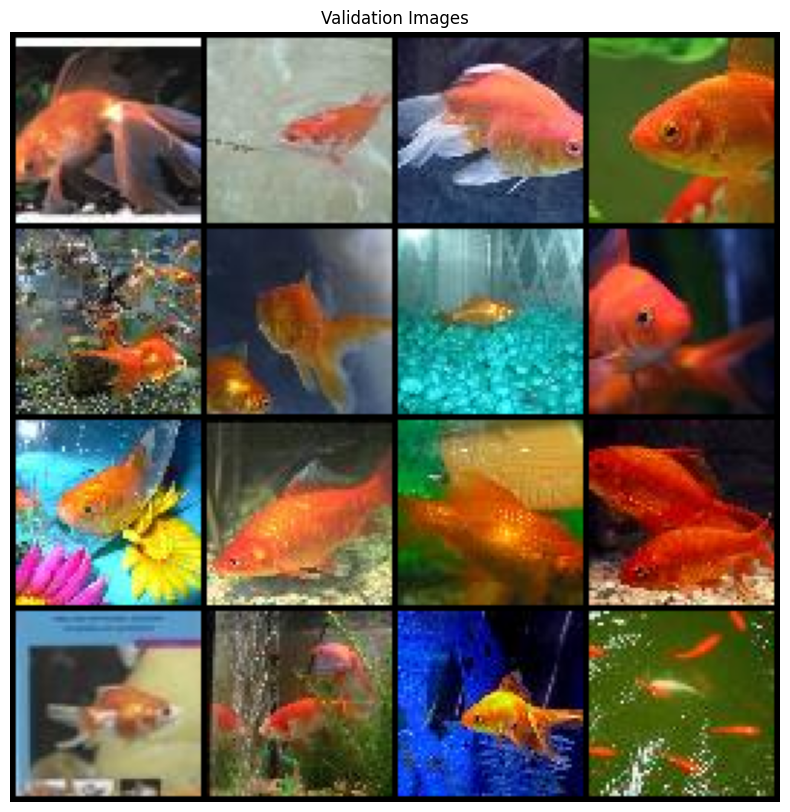

In [9]:
# Function to denormalize images for visualization
def denormalize(image, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# Get a batch of validation data
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)

# Denormalize images for visualization
images = images.clone()
images = torch.stack([denormalize(img) for img in images])

# Create a grid of the first 16 images
grid_img = make_grid(images[:16], nrow=4)

# Plot the grid
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))  # CHW -> HWC
plt.title("Validation Images")
plt.axis('off')
plt.show()

# Part 2.1: Vision Transformer (5 + 10 + 10 + 15 pts)

In [10]:
# In this part, you need to implement the VisionTransformer model for image classification from scratch.

# TODO: Implement the PatchEmbedding class (5 pts)
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        # === TODO ===
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Match stride to patch size to avoid overlap
        self.conv = nn.Conv2d(in_channels, embed_dim, patch_size, patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.dropout = nn.Dropout(0.1)
        # === === ===

    def forward(self, x):
        # === TODO ===
        B, C, H, W = x.shape
        x = self.conv(x).flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches+1, embed_dim)
        x = x + self.pos_embed
        x = self.dropout(x)   
        # === === ===
        return x

# TODO: Implement the MultiHeadSelfAttention class (10 pts)
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embed dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        

        # === TODO ===
        self.scale = self.head_dim ** -0.5

        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        

        # === === ===

    def forward(self, x):
        B, N, C = x.shape
        # === TODO ===
        q = self.Wq(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)
        k = self.Wk(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.Wv(x).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1) + 1e-9 
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.dropout(out)
        return out
    

# TODO: Implement the TransformerEncoderBlock class (10 pts)
#       Use GELU activation function for the feedforward layer
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        # === TODO ===
        self.mhsa = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        # === === ===

    def forward(self, x):
        # === TODO ===
        
        x = x + self.mhsa(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        # === === ===
        return x
    
# TODO: Using PatchEmbedding and TransformerEncoderBlock, implement the complete VisionTransformer class (15 pts)
#       You are expected to follow the design in the original paper for each component, eg dropout, layer norm, mlp head, etc.

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_classes, depth, ff_dim, dropout=0.1):
        super().__init__()
        # === TODO ===
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        # === === ===

    def forward(self, x):
        # === TODO ===
        x = self.patch_embedding(x)

        # Transformer encoder
        for block in self.encoder:
            x = block(x)

        # Classification head
        x = self.norm(x[:, 0])
        x = self.head(x)
        # === === ===
        return x
    

# Part 2.2: Training on Tiny ImageNet (20 pts)

Epoch 1/20
  Train Loss: 4.7732, Train Accuracy: 4.79%
  Val Loss: 4.4306, Val Accuracy: 8.24%
Epoch 2/20
  Train Loss: 4.3059, Train Accuracy: 10.07%
  Val Loss: 4.1494, Val Accuracy: 11.85%
Epoch 3/20
  Train Loss: 4.0622, Train Accuracy: 13.10%
  Val Loss: 3.9033, Val Accuracy: 15.40%
Epoch 4/20
  Train Loss: 3.8880, Train Accuracy: 15.76%
  Val Loss: 3.7814, Val Accuracy: 17.12%
Epoch 5/20
  Train Loss: 3.7481, Train Accuracy: 17.64%
  Val Loss: 3.6117, Val Accuracy: 20.25%
Epoch 6/20
  Train Loss: 3.6274, Train Accuracy: 19.66%
  Val Loss: 3.5395, Val Accuracy: 20.80%
Epoch 7/20
  Train Loss: 3.5193, Train Accuracy: 21.25%
  Val Loss: 3.4865, Val Accuracy: 21.69%
Epoch 8/20
  Train Loss: 3.4162, Train Accuracy: 22.98%
  Val Loss: 3.3702, Val Accuracy: 23.98%
Epoch 9/20
  Train Loss: 3.3253, Train Accuracy: 24.30%
  Val Loss: 3.3486, Val Accuracy: 24.85%
Epoch 10/20
  Train Loss: 3.2282, Train Accuracy: 26.07%
  Val Loss: 3.2690, Val Accuracy: 25.90%
Epoch 11/20
  Train Loss: 3.144

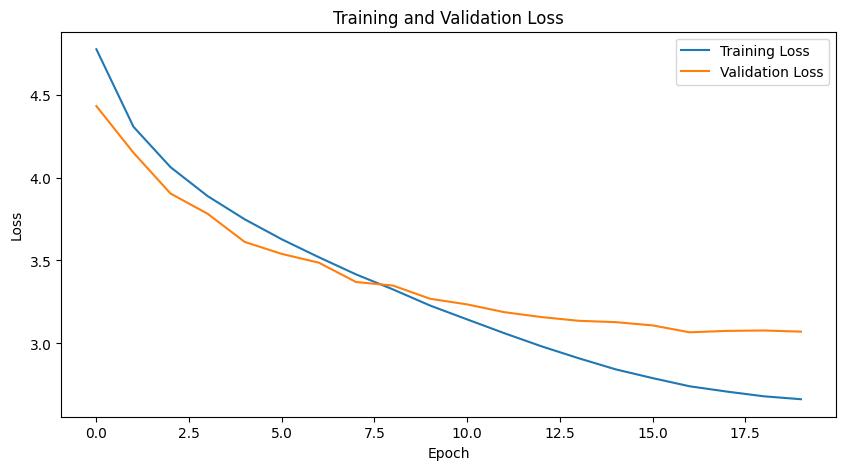

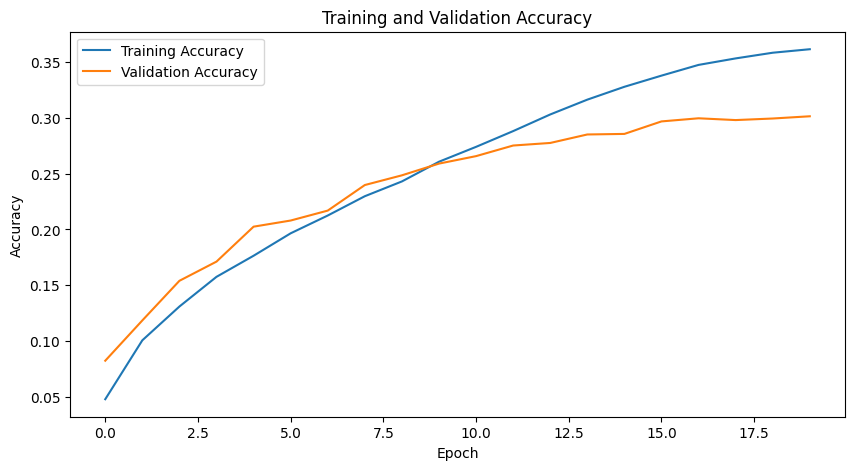

Final Validation Accuracy: 30.14%


In [12]:
# TODO: You will train the VisionTransformer model on the Tiny ImageNet dataset for 20 epochs.
#       You should achieve a validation accuracy of at least 35%.   
#       Set the patch size to 8, embed dim to 128, num heads to 8, depth to 6, and ffdim to 512.
#       Plot the training and validation losses and print the accuracy.




# Hyperparameters
img_size = 64
patch_size = 8
in_channels = 3
embed_dim = 128
num_heads = 8
num_classes = 200
depth = 6
ff_dim = 512
dropout = 0.1
lr = 1e-3
wd = 1e-4
num_epochs = 20

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_channels=in_channels,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_classes=num_classes,
    depth=depth,
    ff_dim=ff_dim,
    dropout=dropout,
).to(device)

# === TODO ===

torch.manual_seed(0)
np.random.seed(0)

# Data loader
batch_size = 64
train_loader = dataloaders['train']
val_loader = dataloaders['val']

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        train_loss += loss.item()
        _, preds = logits.max(1)
        correct_train += preds.eq(y).sum().item()
        total_train += y.size(0)
    scheduler.step()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            # metrics
            val_loss += loss.item()
            _, preds = logits.max(1)
            correct_val += preds.eq(y).sum().item()
            total_val += y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    # Print epoch metrics
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1] * 100:.2f}%")
    print(f"  Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1] * 100:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

final_val_accuracy = val_accuracies[-1] * 100
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

# === === ===

# Part 2.3: QA (4 pts)

Q: What do you observe from the training and validation losses?

A: Training accuracy doesn't reach a high enough value, which makes me think that our model is not expressive enough and we could probably add more layers to improve accuracy overall.

---

Q: What can you do to improve the performance of the model?

A: We can definetly use more data, especially considering we are using transformers. Also, we can add more layers for transformers since our train acc is quite low.

I also played with a learning scheduler a little bit but i didn't fine tune it much. Doing that would probably help quite a bit.